In [2]:
#Import Statements
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output 
from IPython.display import Image
import os
from os import path
import pandas as pd
from scipy.signal import find_peaks
from scipy.stats import mannwhitneyu
import glob
import math
import time

This notebook contains 2 sections. The first is for the pretty picture, and the second is for lab 2 analysis.

## Lab 1: Pretty Picture

We weren't able to take an image during lab 1 due to weather, so that part is here instead.

In [3]:
#Functions used for pretty picture and Lab 2

def fits_data_to_3d_array(file_list): 
    '''
    Takes in a list of fits files and converts data into a 3d array
    Parameters:
        file_list (list): List containing paths of FITS files to convert.
    Returns:
        final_array: 3d array of data from each fits file.
    '''    
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Creates a median combine of a 3d array
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
 
def save_array_to_fits_file(array, new_file_name):
    '''
    Saves a 2d array of pixel data to a FITS file.
    Parameters:
    array(2d): 2d array containing pixel values.
    new_file_name (path): location, name of FITS file to be saved.
    '''  
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name,overwrite=True)


def create_file_list(data_directory, file_name_to_glob, show_list = False):
    
    '''
    This creates a list of all FITS files that will be used.
    
    Parameters:
    data_directory : path to data folder
    file_name_to_glob : name of file containing data (ex.: spectrograph_flats_20s_)
                        This will glob together all files containing this keywords.
    show_list : Show file list for verification.
    '''
    file_list = glob.glob(os.path.join(data_directory, '*' + file_name_to_glob + '*'))
    
    if show_list: 
        for file in file_list: print(file)
            
    return file_list

def cut_pixel_data_array(pixel_data_array, y_pixel_min, y_pixel_max):
    '''
    Returns an array of pixel data, cut to a specified vertical (y-pixel) range.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to create a cut from.
        y_pixel_min (int): Lower bound to start cut. 
        y_pixel_max (int): Upper bound to end cut. 
    Returns:
        final_array: 3d array of data from each fits file.
    '''   
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    pixel_data_array_cut = pixel_data_array[lower_index:upper_index,:]
    print(pixel_data_array_cut.shape)
    return pixel_data_array_cut

def display_2d_array(pixel_data_array, lower_percentile=1, 
            upper_percentile=99,figsize=(6,6),cmap='gray'):
    '''
    Displays a 2d array of pixel data. Useful to see the image contained in a FITS file,
    or to verify successful array data handling.
    Parameters:
        pixel_data_array (2d array): Array of pixel data to display.
        lower_percentile (int): Adjusts the pixel scale lower bound; default = 1
        upper_percentile (int): Adjusts the pixel scale upper bound; default = 99
    '''   
    minimum = np.percentile(pixel_data_array,lower_percentile)
    maximum = np.percentile(pixel_data_array,upper_percentile)
    plt.figure(figsize=figsize)
    plt.imshow(pixel_data_array, cmap=cmap, origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')
    
def glob_files(folder, specifier, asterisks='both', show=False):
    asterisk = "*"
    if asterisks == 'both':
        files = glob.glob(os.path.join(folder, asterisk + specifier + asterisk))
    elif asterisks == 'left':
        files = glob.glob(os.path.join(folder, asterisk + specifier))
    elif asterisks == 'right':
        files = glob.glob(os.path.join(folder, specifier + asterisk))
    if show:
        print(f'Number of Files: {len(files)}')
        for file in files: 
            print(file)
    return files

In [4]:
#Import Files
folder = r"C:\Users\ronan\pretty picture"

#Lights
blue_lights_files = glob_files(folder, "orion_blue_2s", asterisks='both')
ha_lights_files = glob_files(folder, "orion_ha_2s", asterisks='both')
red_lights_files = glob_files(folder, "orion_red_2s", asterisks='both')
visible_lights_files = glob_files(folder, "orion_visible_2s", asterisks='both')

#Flats
blue_flats_files = glob_files(folder, "blue_flat", asterisks='both')
ha_flats_files = glob_files(folder, "ha_flat", asterisks='both')
red_flats_files = glob_files(folder, "red_flat", asterisks='both')
visible_flats_files = glob_files(folder, "visible_flat", asterisks='both')

#Darks
darks_files = glob_files(folder,'dark_2s',show=False)

In [5]:
#Create Frames
blue_lights = fits_data_to_3d_array(blue_lights_files)
ha_lights = fits_data_to_3d_array(ha_lights_files)
red_lights = fits_data_to_3d_array(red_lights_files)
visible_lights = fits_data_to_3d_array(visible_lights_files)

blue_flats = fits_data_to_3d_array(blue_flats_files)
ha_flats = fits_data_to_3d_array(ha_flats_files)
red_flats = fits_data_to_3d_array(red_flats_files)
visible_flats = fits_data_to_3d_array(visible_flats_files)

darks = fits_data_to_3d_array(darks_files)

In [6]:
#Master Frames
master_blue = median_combine(blue_lights)
master_visible = median_combine(visible_lights)
master_red = median_combine(red_lights)
master_ha = median_combine(ha_lights)

master_blue_flats = median_combine(blue_flats)
master_visible_flats = median_combine(visible_flats)
master_red_flats = median_combine(red_flats)
master_ha_flats = median_combine(ha_flats)

master_dark = median_combine(darks)

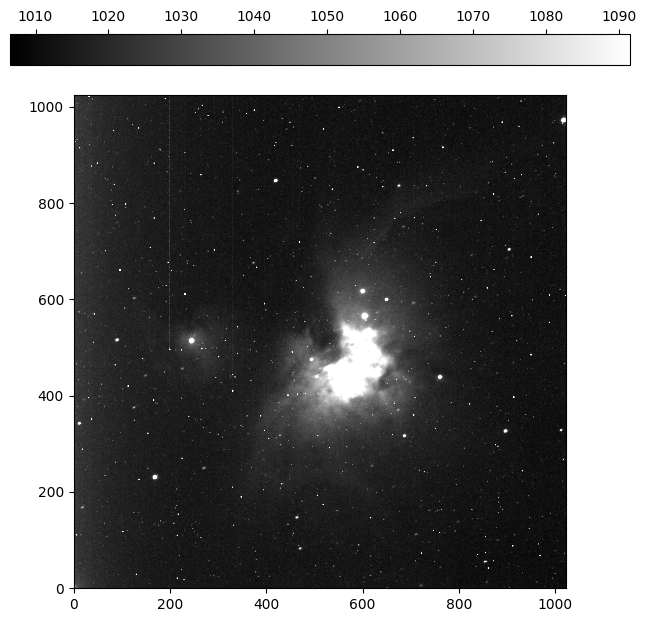

In [7]:
display_2d_array(master_blue,figsize=(8,8))

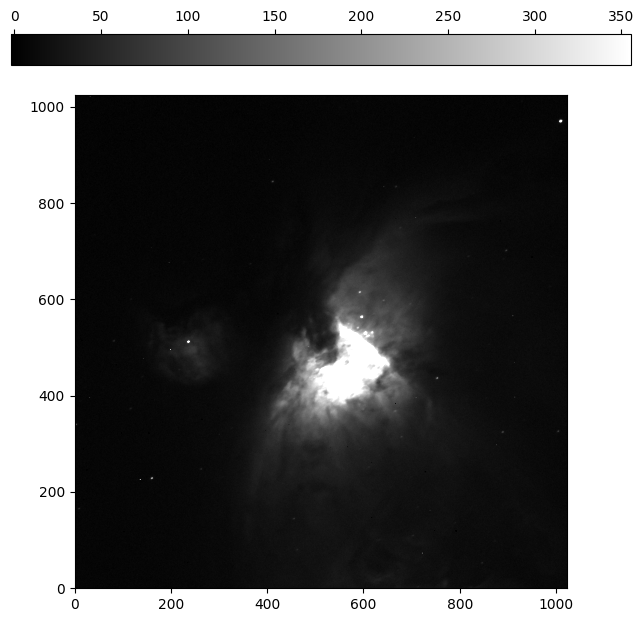

In [8]:
#Dark Subtraction
master_blue_prime = master_blue - master_dark
master_visible_prime = master_visible - master_dark
master_red_prime = master_red - master_dark
master_ha_prime = master_ha - master_dark

master_blue_flats_prime = master_blue_flats - master_dark
master_visible_flats_prime = master_visible_flats - master_dark
master_red_flats_prime = master_red_flats - master_dark
master_ha_flats_prime = master_ha_flats - master_dark

#display_2d_array(1 / (master_ha_prime - master_blue_prime),figsize=(8,8))
display_2d_array(master_ha_prime,figsize=(8,8))

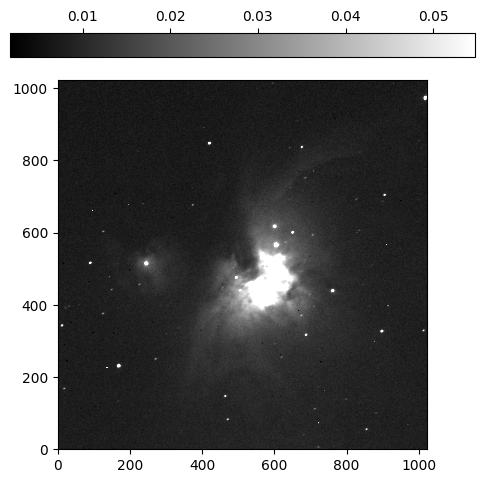

In [9]:
def flat_correction(master_image, master_flat):
    #maximum = np.max(master_flat)
    #const = 1/maximum 
    const = 1 / np.median(master_flat)
    master_flat_normalized = master_flat * const
    master_image = master_image/master_flat_normalized
    master_image = master_image*const
    return master_image

blue_science = flat_correction(master_blue_prime,master_blue_flats_prime)
visible_science = flat_correction(master_visible_prime,master_visible_flats_prime)
red_science = flat_correction(master_red_prime,master_red_flats_prime)
ha_science = flat_correction(master_ha_prime,master_ha_flats_prime)

save_array_to_fits_file(blue_science, 'blue_science.fits')
save_array_to_fits_file(visible_science, 'visible_science.fits')
save_array_to_fits_file(red_science, 'red_science.fits')
save_array_to_fits_file(ha_science, 'ha_science.fits')
display_2d_array(blue_science)

In [10]:
from PIL import Image

# Load blue, green, and red channels from FITS files
blue_data = fits.getdata('blue_science.fits')
green_data = fits.getdata('visible_science.fits')
red_data = fits.getdata('red_science.fits')

# Normalize the data to [0, 255] if necessary
blue_data = np.clip(blue_data, 0, 255).astype(np.uint8)
green_data = np.clip(green_data, 0, 255).astype(np.uint8)
red_data = np.clip(red_data, 0, 255).astype(np.uint8)

# Stack them into an RGB array
rgb_array = np.stack([red_data, green_data, blue_data], axis=-1)

# Convert to an image using Pillow and save or display it
rgb_image = Image.fromarray(rgb_array)
#rgb_image.save('combined_image.png')
#rgb_image.show()

In [11]:
from astropy.io import fits
import numpy as np

# Load the FITS files as NumPy arrays
red_image = fits.getdata('ha_science.fits')
green_image = fits.getdata('red_science.fits')
blue_image = fits.getdata('visible_science.fits')

# Optionally, normalize the images
def normalize_image(data, lower_percentile=1, upper_percentile=99):
    lower = np.percentile(data, lower_percentile)
    upper = np.percentile(data, upper_percentile)
    normalized_data = (data - lower) / (upper - lower) * 255
    return np.clip(normalized_data, 0, 255).astype(np.uint8)

red_image = normalize_image(red_image)
green_image = normalize_image(green_image)
blue_image = normalize_image(blue_image)

In [12]:
from skimage.registration import phase_cross_correlation
from scipy.ndimage import shift

# Function to align two images using cross-correlation
def align_images_translation(image1, image2):
    # Calculate the shift between the images
    shift_yx, error, diffphase = phase_cross_correlation(image1, image2)
    print(f"Shift: {shift_yx}, Error: {error}")

    # Apply the shift to image2
    aligned_image2 = shift(image2, shift_yx)

    return aligned_image2

# Align green and blue channels to the red channel
aligned_green = align_images_translation(red_image, green_image)
aligned_blue = align_images_translation(red_image, blue_image)

Shift: [0. 0.], Error: 1.0
Shift: [0. 0.], Error: 1.0


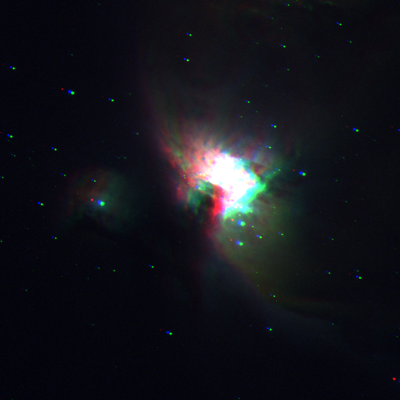

In [13]:
from PIL import Image

# Stack the aligned channels into an RGB array
rgb_array = np.stack([red_image, aligned_green, aligned_blue], axis=-1)

# Convert to an image and display/save
rgb_image = Image.fromarray(rgb_array.astype(np.uint8))
#rgb_image.show()  # Display the image
Image.open(r"C:\Users\ronan\aligned_rgb_image.png").resize((400,400))# Save the image

Manual alignment was done on ds9. The resulting image is below:


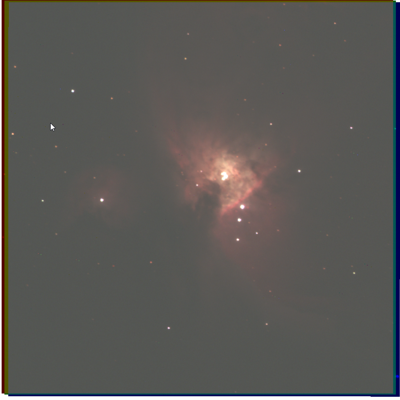

In [14]:
print("Manual alignment was done on ds9. The resulting image is below:")
Image.open(r"C:\Users\ronan\Downloads\pretty_orig.png").resize((400,400))

another variation of the same image, done in DS9 as well using a RGB frame


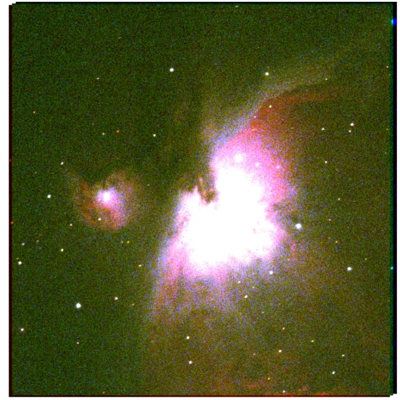

In [15]:
print("another variation of the same image, done in DS9 as well using a RGB frame")
Image.open(r"C:\Users\ronan\pretty_alt.JPEG").resize((400,400))

--------------------------------------------------------

## Lab 2 Analysis

In [16]:
#essential functions. There is some repitition compared to the lab 1 pretty picture analysis, 
#since the analyses were kept separate.

#Inputs a list of fits file paths, and outputs their data concatenated in a 3d ndarray.
#The resulting array has dimensions (file_index,x,y).
def fits_data_to_3d_array(file_list): 
    for i, file in enumerate(file_list):
        with fits.open(file) as hdu:
            if i==0:  #If first iteration, create array with correct shape of data
                final_array = np.zeros((len(file_list), *hdu[0].data.shape))
            final_array[i,:,:] = hdu[0].data
    return final_array

#Takes in a 3d array from the above function, and takes a median along the file_index axis.
#Returns a 2d array representing the median image.
def median_combine(frame_array_3d):
    master_frame = np.median(frame_array_3d,axis=0) 
    return master_frame

#Like the above function, but takes a mean.
def mean_combine(frame_array_3d):
    master_frame = np.mean(frame_array_3d,axis=0) #takes median along the 'file_index' axis
    return master_frame
    
#Takes in a 2d array, saves as a fits file with no specifications on a header for viewing in ds9.
def save_array_as_fits(array, new_file_name):
    hdu = fits.PrimaryHDU(data = array)
    hdul = fits.HDUList([hdu])
    hdul.writeto(new_file_name)

#Cuts out parts of an array along the y-axis. Used in spectroscopy to cut out the two irrelevant slits.
def cut_images_array(image_array, y_pixel_min, y_pixel_max):
    lower_index = (-1) + y_pixel_min
    upper_index = (-1) + y_pixel_max
    image_array_cut = image_array[lower_index:upper_index,:]
    print(image_array_cut.shape)
    return image_array_cut

#Used to display part or all of the spectrum image; takes a 2d array as input.
def display_2d_array(image_array, lower_percentile=1, upper_percentile=99):
    minimum = np.percentile(image_array,lower_percentile)
    maximum = np.percentile(image_array,upper_percentile)
    plt.imshow(image_array, cmap='gray', origin = 'lower', vmin=minimum, vmax=maximum)
    plt.colorbar(location='top')

## 4.1

## Notes on the files:

In the pretty picture folder (a folder called "pretty picture" in the same directory as the notebook, containing all the darks, flats, and orion lights fits files): flats of .5s and sciences of 2s for each of the filters we used, and 18s darks which are filter agnostic. 

In the Lab 2 folder (a folder called "Lab 2" in the same directory as the notebook, containing all the lab 2 lights fits files): Hundreds of 18s blue filter lights. Unless a change is made to the file structure, use the pretty picture folder's 18s darks and blue flats, based on where files were initially saved

Additional notes I took during the observation. Note that python(starts counting at 0) and the file structure(starts counting at 1 in CCDSoft) disagree on file number labels:
    
    The first science file is at 10:59 PM.
    
    Strange background brightness change in frame 9?
    
    Dome was rotated 180 degrees on frame ~26, at 11:08 PM. 
    
    The meridian flip started 11:30, frame ~83. We had found the stars again by 11:46(maybe some frames before?), frame ~120. 
    
    Telescope was moved between 12:14 and 12:17, frames ~197-201.
    
    Moved again 12:33, frame ~245.
    
    The last frame was at 12:53.
    
    The original science frame 148(counting from 0) was could not be downloaded, so for calibrated images and everything(astrometric solns, extracted catalogs, etc) after, it should be understood that 148-298 correspond to the original 149-299.

Create the master flat and dark frames.

In [17]:
long_darks_3d_array = fits_data_to_3d_array(glob_files("pretty picture","orion_dark_18s"))
short_darks_3d_array = fits_data_to_3d_array(glob_files("pretty picture","orion_dark_.5s"))
flats_3d_array = fits_data_to_3d_array(glob_files("pretty picture","orion_blue_flat"))

masterdark_long = median_combine(long_darks_3d_array)
masterdark_short = median_combine(short_darks_3d_array)
masterflat = median_combine(flats_3d_array)
masterflat_normalized = (masterflat - masterdark_short) / np.median(masterflat - masterdark_short)
#is this right?

Calibrate the science images and save them.

In [18]:
sciences_3d_array = fits_data_to_3d_array(glob_files("Lab 2","HATP6_blue_lights_18s"))

sciences_3d_array_calibrated = sciences_3d_array.copy()
num_science_files = len(sciences_3d_array_calibrated[:,0,0])
for i in range(num_science_files):
    sciences_3d_array_calibrated[i,:,:] = (sciences_3d_array_calibrated[i,:,:] - 
                                    masterdark_long) / masterflat_normalized
    save_array_to_fits_file(sciences_3d_array_calibrated[i,:,:], f"new_lab2_calibration/new_science_calib_{i}.fits")

Check a sample of the images in ds9 to see if they make sense. They do.

## 4.2

In [19]:
#check the header of a solved file: This file has a lot 
with fits.open(r"C:\Users\ronan\final_solutions_lab2\new_science_calib_0.fits") as hdu:
            print(hdu[0].header)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                 1024                                                  NAXIS2  =                 1024                                                  EXTEND  =                    T                                                  COMMENT Original key: "END"                                                     COMMENT                                                                         COMMENT --Start of Astrometry.net WCS solution--                                COMMENT --Put in by the new-wcs program--                                       COMMENT                                                                         WCSAXES =                    2 / no comment                                     CTYPE1  = 'RA---TAN-SIP' / TAN (gnomic) 

The radius of the circle containing about all of and only our star made is ~11 pixels, centered at 23:39:05.6 +42:27:57.7.

## 4.3

Now, we run source extractor. The resulting catalogues are in the new_final_ext_out directory.

In [4]:
#we first need to make usable dataframes out of the produced csv files, which do not come out of sextractor neatly.
column_titles = ['object_index',          #
                 'x',                     #pix
                 'y',                     #pix
                 'barycenter_ra',         #deg
                 'barycenter_dec',        #deg
                 'aperture_flux',         #count
                 'aperture_flux_error',   #count
                 'flux_radius',           #pix
                 'gaussian_fwhm',         #pix
                 'background',            #count
                 'threshold',             #count
                 'flux_max',              #count
                 'isoarea_image',         #pix**2
                 'prof_rms_major_axis',   #pix
                 'prof_rms_minor_axis',   #pix
                 'pos_angle',             #pix
                 'flags']                 #deg
#The files come in an awkward format. Turn them into normal dataframes:
#This function acts on one of the images, and its rows represent different detected objects.
#different files have different sets/numbers of detected objects, 
# so we have to match ra+dec (both in degrees), not object number.
def dataframe_from_catalog(file): 
    catalog_df = pd.read_csv(file)
    list_of_lists = []
    for i in range(16,len(catalog_df)):
        temp_list = catalog_df.iloc[i][0].split()
        for j in range(len(temp_list)):
            temp_list[j] = float(temp_list[j])
        temp_list[0] = int(temp_list[0])
        temp_list[-1] = int(temp_list[-1])
        list_of_lists.append(temp_list)
        final_df = pd.DataFrame(list_of_lists,columns=column_titles)
        clear_output(wait = True)
        times_list = []
        file_index = int(file.split('_')[-1].split('.')[0]) #files were named like catalogue_lab2_INDEX.fits
        if file_index < 148:
            t = 1.9 * file_index / 300.
        else:
            t = 1.9 * (file_index + 1.) / 300.
        final_df.insert(7, 'time', t)
    return final_df
   
print(dataframe_from_catalog('new6_final_ext_out/new6_catalog_lab2_9.csv')) #The form we want 
#for an example file!####################################
#This should have appended to it a column of all the same time

     object_index         x          y  barycenter_ra  barycenter_dec  \
0               1  172.7031    18.8505     354.604129       42.766910   
1               2  336.6120     6.5920     354.570925       42.703148   
2               3  422.4013     1.2324     354.554146       42.669646   
3               4  272.9149  1008.1302     355.122703       42.607976   
4               5  785.7020  1004.1550     355.036160       42.404770   
..            ...       ...        ...            ...             ...   
185           186  563.8896    29.2798     354.546458       42.610002   
186           187   55.4124    20.7747     354.624216       42.813348   
187           188  765.9554  1017.3782     355.046515       42.411012   
188           189  482.2494    14.9886     354.551916       42.644192   
189           190  839.6770  1009.4879     355.030176       42.382680   

     aperture_flux  aperture_flux_error   time  flux_radius  gaussian_fwhm  \
0        5863.5820            104.59510  0.05

Since this next function is time-consuming to run, we will save the results as files.

In [5]:
#now to make the light curve data frame. This function looks in a 10-as square centered on (ra,dec)
#Produces a dataframe with, most importantly, aperture flux, aperture flux error, and timestamp. And a bunch of other stuff.
#And now, it rejects stars on the outskirts.
def generate_lightcurve_df(ra, dec): #must give ra, dec of target object in decimal degrees.
    file_list = glob_files('new6_final_ext_out', 'new6_catalog_lab2')
    init_df = dataframe_from_catalog(file_list[0])
    current_df = init_df[(np.fabs(init_df['barycenter_ra']-ra) < .003) & (np.fabs
    (init_df['barycenter_dec']-dec) < .003) &
    (init_df['x'] < 999) & (init_df['x'] > 25) & (init_df['y'] < 999) & (init_df['y'] > 25)] 
    for file in file_list[1:]:
        cat_df = dataframe_from_catalog(file)
        #time.sleep(.3)
        limited_df = cat_df[(np.fabs(cat_df['barycenter_ra']-ra) < .003) & (np.fabs
                    (cat_df['barycenter_dec']-dec) < .003) &
        (cat_df['x'] < 999) & (cat_df['x'] > 25) & (cat_df['y'] < 999) & (cat_df['y'] > 25)] #the df
        current_df = pd.concat([current_df, limited_df])
    return current_df

In [ ]:
hat_p_6_lightcurve_df = generate_lightcurve_df(354.775,42.46611)
#for some reason the dataframe wasn't displaying if I ran it right after the above function, so I made Python wait
time.sleep(1)

hat_p_6_lightcurve_df

The important columns are titled 'aperture_flux', 'aperture_flux_error', and 'time'. 
#### Fluxes are in counts and time is in hours after 10:59 PM.

In [ ]:
ref_df_1 = generate_lightcurve_df(354.6,42.50278)
time.sleep(1)

ref_df_1

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
146,147,800.6921,171.0310,354.601019,42.502988,10750.490,105.4099,0.000000,1.363,2.59,63.30581,24.78594,1368.0030,41.0,1.290,1.029,-50.96,0
147,148,798.7162,173.6994,354.601021,42.503013,10954.110,105.4855,0.006333,1.321,2.63,62.86795,24.76867,1422.2040,43.0,1.267,1.115,-81.13,0
147,148,780.8467,198.5398,354.600980,42.502970,10932.160,104.6573,0.063333,1.333,2.67,60.55962,24.60026,1438.2500,37.0,1.234,0.998,-45.20,0
123,124,29.7165,544.7089,354.601093,42.502989,6781.501,103.7023,0.665000,1.260,2.40,56.64621,24.34997,907.1151,31.0,1.137,0.941,-18.12,0
96,97,32.7771,541.9953,354.601048,42.503033,10507.330,103.2362,0.671333,1.321,2.52,56.55949,24.27481,1388.5220,36.0,1.158,1.021,-73.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,120,627.8183,366.5871,354.601047,42.503009,10626.360,103.1702,0.500333,1.358,2.65,55.91215,24.25930,1456.6290,41.0,1.260,1.040,-42.33,0
142,143,785.1356,192.8292,354.601014,42.503008,10533.010,104.2563,0.050667,1.400,2.84,60.67641,24.51035,1233.2050,43.0,1.368,1.065,-68.41,0
114,115,625.5032,368.4563,354.601079,42.503066,10566.950,103.5989,0.506667,1.283,2.55,55.95347,24.33427,1377.3750,44.0,1.322,1.024,-16.10,0
87,88,623.2759,370.7910,354.601142,42.503010,8470.083,102.2514,0.513000,7.389,2.71,50.94966,24.04324,828.7260,127.0,11.639,1.391,-13.43,3


In [7]:
ref_df_2 = generate_lightcurve_df(354.74583,42.41028)
time.sleep(1)

ref_df_2

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
92,93,940.0638,481.5879,354.745913,42.410459,12246.280,105.3913,0.000000,1.304,2.45,63.66917,24.78594,1847.785,40.0,1.191,1.006,-36.79,0
90,91,938.1509,484.2885,354.745932,42.410443,12258.390,105.3924,0.006333,1.211,2.22,62.74480,24.76867,1870.948,35.0,1.152,0.914,-52.11,0
94,95,920.1240,509.2179,354.745920,42.410455,12357.940,104.5462,0.063333,1.362,2.92,60.44130,24.60026,1525.233,41.0,1.282,0.967,-51.50,0
93,94,918.2664,512.3064,354.745925,42.410455,12162.350,104.3285,0.069667,1.186,2.41,60.41802,24.50999,1698.029,33.0,1.161,0.844,-46.33,0
166,167,26.8569,104.9025,354.746040,42.410526,12454.330,103.5085,0.715667,1.466,3.00,54.62203,24.31733,1362.762,40.0,1.318,1.058,-44.27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,766.7200,677.2974,354.745929,42.410515,12084.830,103.3161,0.500333,1.178,2.40,55.43416,24.25930,2087.666,33.0,1.117,0.868,-39.22,0
92,93,924.4097,503.4989,354.745967,42.410490,12042.910,104.2195,0.050667,1.320,2.68,60.53075,24.51035,1488.167,36.0,1.255,0.927,-63.71,0
53,54,764.4922,679.2657,354.745997,42.410526,12373.980,103.5806,0.506667,1.140,2.38,55.56779,24.33427,2084.812,34.0,1.125,0.841,-23.73,0
37,38,762.1833,681.3538,354.745946,42.410527,8379.528,102.3056,0.513000,1.314,2.44,50.80869,24.04324,1070.024,36.0,1.187,1.003,-65.16,0


In [8]:
ref_df_3 = generate_lightcurve_df(354.7042,42.6736)
time.sleep(1)

ref_df_3

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
138,139,354.8784,228.1889,354.704112,42.673528,136406.40,105.3726,0.000000,1.440,2.68,63.07568,24.78594,16285.69,109.0,1.435,1.238,-53.97,0
140,141,352.9794,230.9552,354.704168,42.673527,135623.40,105.3924,0.006333,1.415,2.53,62.59610,24.76867,17859.12,99.0,1.374,1.200,-56.78,0
141,142,334.9818,255.7373,354.704166,42.673512,136598.20,104.6388,0.063333,1.423,2.77,60.55416,24.60026,17555.84,108.0,1.441,1.201,-57.24,0
120,121,450.0516,498.4125,354.704204,42.673647,111976.20,103.7124,0.646000,1.281,2.28,55.31463,24.38247,16137.54,93.0,1.278,1.119,-58.82,0
125,126,451.9766,496.3465,354.704262,42.673485,109460.00,103.4827,0.652333,1.262,2.24,55.46968,24.32418,16485.55,106.0,1.277,1.228,2.81,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,110,182.0329,423.1371,354.704157,42.673525,136562.40,103.1702,0.500333,1.349,2.58,55.82930,24.25930,16602.80,104.0,1.355,1.155,-48.15,0
135,136,339.3221,250.0366,354.704186,42.673543,136205.20,104.2195,0.050667,1.461,2.82,60.37817,24.51035,13552.52,121.0,1.499,1.253,-73.94,0
105,106,179.7665,425.0100,354.704154,42.673542,137037.70,103.5440,0.506667,1.353,2.63,55.88923,24.33427,20208.42,114.0,1.347,1.157,-31.51,0
82,83,177.4668,427.1875,354.704173,42.673524,92901.26,102.2514,0.513000,1.473,2.69,50.60789,24.04324,10436.50,98.0,1.441,1.236,-74.68,0


In [6]:
ref_df_4 = generate_lightcurve_df(354.7833,42.6617)
time.sleep(1)

ref_df_4

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
111,112,340.8242,373.5942,354.785041,42.661706,26387.48,105.4099,0.000000,1.457,2.68,63.40973,24.78594,3305.964,60.0,1.369,1.138,-49.18,0
112,113,338.8931,376.3327,354.785095,42.661717,26647.61,105.4669,0.006333,1.351,2.43,62.51038,24.76867,3381.120,59.0,1.315,1.132,-56.01,0
115,116,320.8893,401.1261,354.785088,42.661699,26201.89,104.7867,0.063333,1.371,2.65,60.43650,24.60026,3258.220,52.0,1.297,1.094,-52.16,0
146,147,467.0810,353.2982,354.785105,42.661775,21517.83,103.8224,0.646000,1.322,2.39,55.06718,24.38247,2772.090,49.0,1.233,1.071,-54.07,0
153,154,469.0622,351.2224,354.785212,42.661685,21100.46,103.4278,0.652333,1.288,2.37,55.19858,24.32418,2769.173,47.0,1.172,1.078,-43.36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,78,167.7462,568.5384,354.785107,42.661722,27273.96,103.2067,0.500333,1.285,2.50,55.73145,24.25930,3726.298,58.0,1.261,1.052,-40.93,0
110,111,325.2374,395.4171,354.785108,42.661729,26261.40,104.2932,0.050667,1.463,2.76,60.51082,24.51035,2862.814,53.0,1.373,1.123,-66.89,0
72,73,165.4903,570.4263,354.785103,42.661729,27089.84,103.4891,0.506667,1.267,2.53,56.13773,24.33427,3509.675,50.0,1.235,1.014,-30.46,0
56,57,163.2124,572.5432,354.785093,42.661707,18428.40,102.2694,0.513000,1.408,2.60,50.69240,24.04324,2029.016,50.0,1.315,1.114,-74.01,0


In [10]:
ref_df_5 = generate_lightcurve_df(354.6167,42.5139)
time.sleep(1)

ref_df_5

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
109,110,290.4190,595.2981,354.616685,42.514947,33948.75,102.8978,1.266667,3.151,15.83,52.58085,24.20811,2448.561,147.0,4.412,1.579,-31.77,3
101,102,342.1695,563.3716,354.617911,42.516550,40088.02,102.6170,1.551667,3.735,12.38,52.52394,24.12068,4719.501,194.0,5.245,1.577,-26.99,3


In [11]:
ref_df_6 = generate_lightcurve_df(354.6417,42.6831)
time.sleep(1)

ref_df_6

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
157,158,364.6474,114.7847,354.641165,42.683184,15054.590,105.4286,0.000000,1.456,2.79,62.95153,24.78594,1787.147,51.0,1.394,1.129,-42.19,0
158,159,362.7264,117.5604,354.641225,42.683192,15130.900,105.3365,0.006333,1.418,2.63,62.75475,24.76867,1825.155,47.0,1.304,1.126,-56.22,0
159,160,344.7611,142.3386,354.641225,42.683168,15097.480,104.6018,0.063333,1.421,2.74,59.85789,24.60026,1683.433,47.0,1.334,1.091,-53.01,0
89,90,438.0022,611.5846,354.641302,42.683352,12516.990,103.5839,0.646000,1.253,2.15,55.16995,24.38247,1951.681,38.0,1.155,0.999,-46.31,0
101,102,439.8940,609.5469,354.641313,42.683141,12157.160,103.5925,0.652333,1.240,2.22,55.36835,24.32418,1891.751,40.0,1.112,1.014,-32.55,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,135,191.9872,309.7399,354.641198,42.683163,15041.290,103.1884,0.500333,1.376,2.79,55.83651,24.25930,2036.975,43.0,1.262,1.083,-51.87,0
154,155,349.1451,136.7375,354.641287,42.683169,15203.130,104.3116,0.050667,1.505,2.97,60.23217,24.51035,1606.333,52.0,1.416,1.147,-65.57,0
129,130,189.7047,311.6789,354.641237,42.683181,14855.590,103.6172,0.506667,1.348,2.64,55.53947,24.33427,2139.500,45.0,1.244,1.053,-23.79,0
116,117,187.4004,313.8525,354.641249,42.683168,9979.044,102.1790,0.513000,1.477,2.71,50.64259,24.04324,1105.135,42.0,1.333,1.113,-71.05,0


In [ ]:
ref_df_7 = generate_lightcurve_df(354.9,42.5817)
time.sleep(1)

ref_df_7

C:\Users\tdavd\AppData\Local\Temp\ipykernel_61324\126491933.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp_list = catalog_df.iloc[i][0].split()


In [13]:
ref_df_8 = generate_lightcurve_df(354.7792,42.6897)
time.sleep(1)

ref_df_8

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
118,119,278.1067,347.1398,354.780958,42.689818,18547.54,105.4659,0.000000,1.409,2.72,63.45222,24.78594,2113.553,49.0,1.326,1.099,-51.18,0
118,119,276.1707,349.8584,354.781003,42.689837,18389.29,105.3551,0.006333,1.344,2.43,62.71299,24.76867,2486.459,46.0,1.235,1.078,-60.87,0
123,124,258.1758,374.6586,354.781008,42.689811,18799.82,104.6573,0.063333,1.381,2.68,60.39438,24.60026,2378.592,50.0,1.311,1.078,-56.20,0
142,143,529.2997,381.0336,354.781041,42.689911,15163.53,103.6940,0.646000,1.277,2.30,54.96871,24.38247,2110.520,42.0,1.208,1.002,-53.12,0
146,147,531.2847,378.9882,354.781124,42.689824,14763.89,103.3912,0.652333,1.247,2.34,55.15771,24.32418,2133.614,41.0,1.120,1.037,-37.04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,87,105.0687,542.0021,354.781029,42.689833,18928.81,103.1519,0.500333,1.294,2.61,55.87321,24.25930,2657.857,43.0,1.193,0.995,-44.01,0
117,118,262.5781,368.9564,354.781020,42.689820,18777.33,104.2748,0.050667,1.443,2.79,60.55981,24.51035,2083.623,51.0,1.341,1.133,-71.35,0
80,81,102.7867,543.8912,354.781027,42.689848,19015.87,103.4524,0.506667,1.303,2.63,56.16601,24.33427,2832.447,46.0,1.199,1.040,-29.35,0
64,65,100.5476,546.0017,354.781010,42.689811,12928.68,102.1790,0.513000,1.421,2.59,50.70842,24.04324,1537.742,45.0,1.309,1.112,-83.30,0


In [14]:
ref_df_9 = generate_lightcurve_df(354.5833,42.6317)
time.sleep(1)

ref_df_9

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
171,172,513.5178,51.0393,354.582578,42.631543,66010.22,105.4286,0.000000,1.421,2.68,62.79660,24.78594,7347.500,80.0,1.378,1.196,-45.65,0
172,173,511.6328,53.7966,354.582615,42.631535,65777.57,105.3365,0.006333,1.375,2.53,62.59409,24.76867,8735.592,70.0,1.328,1.120,-54.81,0
173,174,493.6480,78.6261,354.582633,42.631524,65693.06,104.6573,0.063333,1.417,2.85,59.82204,24.60026,7710.604,74.0,1.383,1.131,-48.10,0
74,75,287.8419,672.2737,354.582723,42.631742,54554.14,103.6940,0.646000,1.201,1.99,55.33389,24.38247,9153.887,67.0,1.159,1.040,-54.54,0
88,89,289.7418,670.2897,354.582696,42.631504,53518.48,103.5925,0.652333,1.242,2.33,55.77831,24.32418,7503.470,71.0,1.206,1.081,-43.13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,146,340.9088,246.2177,354.582613,42.631526,65548.97,103.0972,0.500333,1.394,2.64,55.96713,24.25930,8007.306,74.0,1.368,1.138,-47.25,0
167,168,498.0087,72.9550,354.582664,42.631538,65249.21,104.2195,0.050667,1.462,3.00,60.21986,24.51035,7066.155,84.0,1.457,1.198,-66.99,0
139,140,338.6338,248.0886,354.582627,42.631557,65592.23,103.4891,0.506667,1.349,2.65,55.55944,24.33427,9321.929,83.0,1.342,1.158,-28.08,0
128,129,336.3502,250.2731,354.582629,42.631538,44058.50,102.3418,0.513000,1.511,2.73,50.79030,24.04324,4559.063,70.0,1.424,1.228,-70.80,0


In [15]:
ref_df_10 = generate_lightcurve_df(354.6708,42.4456)
time.sleep(1)

ref_df_10

,object_index,x,y,barycenter_ra,barycenter_dec,aperture_flux,aperture_flux_error,time,flux_radius,gaussian_fwhm,background,threshold,flux_max,isoarea_image,prof_rms_major_axis,prof_rms_minor_axis,pos_angle,flags
120,121,897.4571,332.7120,354.672591,42.445210,10520.470,105.5404,0.000000,1.300,2.60,63.05689,24.78594,1437.4600,35.0,1.191,0.978,-48.10,0
121,122,895.5180,335.5238,354.672669,42.445196,10590.450,105.5227,0.006333,1.160,2.33,62.33678,24.76867,1486.9190,32.0,1.146,0.889,-50.92,0
125,126,877.5533,360.3730,354.672622,42.445192,10177.880,104.6758,0.063333,1.285,2.73,60.42808,24.60026,1404.2700,33.0,1.239,0.895,-49.36,0
123,124,875.6975,363.4229,354.672604,42.445203,10358.920,104.1995,0.069667,1.204,2.45,60.41601,24.50999,1534.0820,33.0,1.149,0.890,-46.76,0
135,136,63.6023,257.3261,354.672775,42.445259,10635.190,103.0473,0.709333,1.378,2.80,54.99881,24.23469,1271.7020,33.0,1.247,0.958,-53.24,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,89,724.3102,528.3770,354.672614,42.445259,10121.860,103.1519,0.500333,1.210,2.47,55.65134,24.25930,1561.7670,35.0,1.189,0.932,-39.98,0
119,120,881.8396,354.7260,354.672701,42.445220,10451.240,104.2379,0.050667,1.332,2.86,60.38976,24.51035,1313.3640,33.0,1.230,0.922,-61.69,0
84,85,722.0814,530.3602,354.672693,42.445270,10152.420,103.5257,0.506667,1.168,2.46,56.03046,24.33427,1468.4660,30.0,1.127,0.838,-24.10,0
66,67,719.8027,532.4984,354.672660,42.445256,6942.694,102.1971,0.513000,1.361,2.45,50.95796,24.04324,926.6523,35.0,1.246,1.014,-56.54,0


In [7]:
save the above to CSVs, directly into the local directory.
ref_df_1.to_csv('final6_ref_df_1.csv')
ref_df_2.to_csv('final6_ref_df_2.csv')
ref_df_3.to_csv('final6_ref_df_3.csv')
ref_df_4.to_csv('final6_ref_df_4.csv')
ref_df_5.to_csv('final6_ref_df_5.csv')
ref_df_6.to_csv('final6_ref_df_6.csv')
ref_df_7.to_csv('final6_ref_df_7.csv')
ref_df_8.to_csv('final6_ref_df_8.csv')
ref_df_9.to_csv('final6_ref_df_9.csv')
ref_df_10.to_csv('final6_ref_df_10.csv')
hat_p_6_lightcurve_df.to_csv('final6_hat_p_6_lightcurve_df.csv') #done

In [4]:
#CSVs => dfs, directly from the local directory. And sort them by time.
ref_df_1 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_1.csv").sort_values("time")
ref_df_2 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_2.csv").sort_values("time")
ref_df_3 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_3.csv").sort_values("time")
ref_df_4 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_4.csv").sort_values("time")
ref_df_5 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_6.csv").sort_values("time")
ref_df_6 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_8.csv").sort_values("time")
ref_df_7 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_9.csv").sort_values("time")
ref_df_8 = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_ref_df_10.csv").sort_values("time")
hat_p_6_lightcurve_df = pd.read_csv(r"C:\Users\ronan\lightcurves_df_6pix_aperture\final6_hat_p_6_lightcurve_df.csv"
                                   ).sort_values("time")

Note: It didn't work on 5 and 7. They didn't get picked up by source extractor. Therefore, file indices do not match the dataframe names from here on!

## 4.4

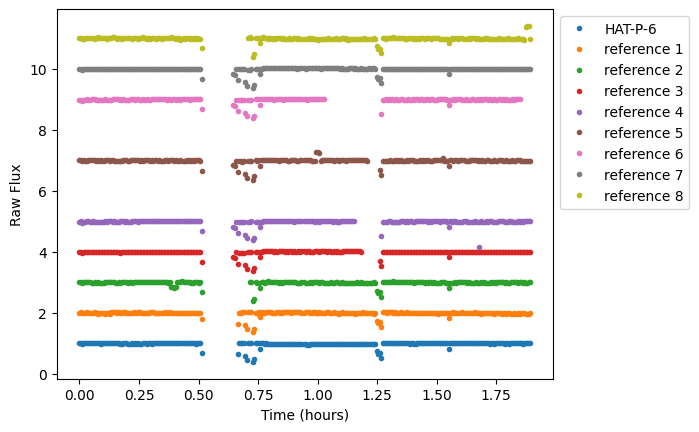

In [17]:
#Display data, with an offset

fig, ax = plt.subplots()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Raw Flux')
ax.plot(hat_p_6_lightcurve_df['time'],hat_p_6_lightcurve_df['aperture_flux'
        ]/np.median(hat_p_6_lightcurve_df['aperture_flux']),'.',label='HAT-P-6')
ax.plot(ref_df_1['time'],1+ref_df_1['aperture_flux']/np.median(ref_df_1['aperture_flux']),'.',label='reference 1')
ax.plot(ref_df_2['time'],2+ref_df_2['aperture_flux']/np.median(ref_df_2['aperture_flux']),'.',label='reference 2')
ax.plot(ref_df_3['time'],3+ref_df_3['aperture_flux']/np.median(ref_df_3['aperture_flux']),'.',label='reference 3')
ax.plot(ref_df_4['time'],4+ref_df_4['aperture_flux']/np.median(ref_df_4['aperture_flux']),'.',label='reference 4')
ax.plot(ref_df_5['time'],6+ref_df_5['aperture_flux']/np.median(ref_df_5['aperture_flux']),'.',label='reference 5')
ax.plot(ref_df_6['time'],8+ref_df_6['aperture_flux']/np.median(ref_df_6['aperture_flux']),'.',label='reference 6')
ax.plot(ref_df_7['time'],9+ref_df_7['aperture_flux']/np.median(ref_df_7['aperture_flux']),'.',label='reference 7')
ax.plot(ref_df_8['time'],10+ref_df_8['aperture_flux']/np.median(ref_df_8['aperture_flux']),'.',label='reference 8')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

Now HAT-P-6's original base lightcurve alone:

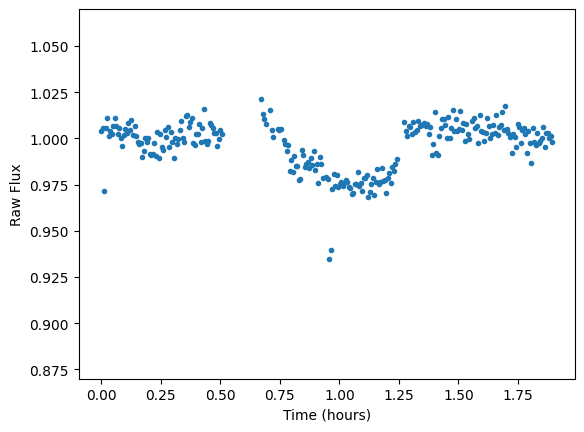

In [16]:
fig, ax = plt.subplots()
ax.set_ylim(.87,1.07)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Raw Flux')
ax.plot(hat_p_6_lightcurve_df['time'],hat_p_6_lightcurve_df['aperture_flux'
        ]/np.median(hat_p_6_lightcurve_df['aperture_flux']),'.',label='HAT-P-6')

It's clear that dataframe 6 is missing a significant area. But, It'd be nice not to lose those timestamps for the other lightcurves. The lack of some points will be recorded as higher uncertainties in some places.

<ErrorbarContainer object of 3 artists>

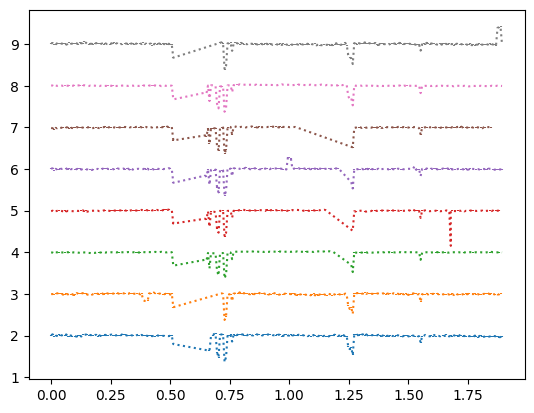

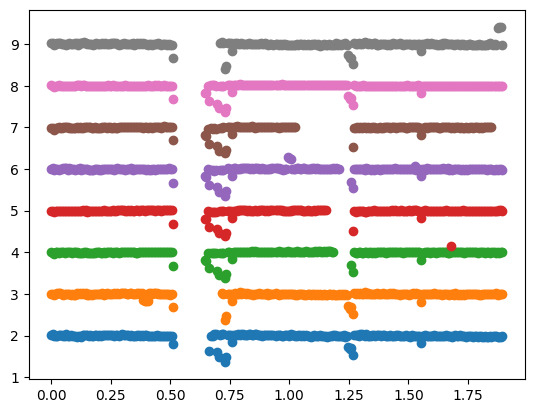

In [19]:
fig, ax = plt.subplots()
ax.errorbar(ref_df_1['time'], 1+ref_df_1['aperture_flux']/np.median(
    ref_df_1['aperture_flux']),ls='dotted', yerr=ref_df_1['aperture_flux_error']/np.median(ref_df_1['aperture_flux']))
ax.errorbar(ref_df_2['time'], 2+ref_df_2['aperture_flux']/np.median(
    ref_df_2['aperture_flux']),ls='dotted', yerr=ref_df_2['aperture_flux_error']/np.median(ref_df_2['aperture_flux']))
ax.errorbar(ref_df_3['time'], 3+ref_df_3['aperture_flux']/np.median(
    ref_df_3['aperture_flux']),ls='dotted', yerr=ref_df_3['aperture_flux_error']/np.median(ref_df_3['aperture_flux']))
ax.errorbar(ref_df_4['time'], 4+ref_df_4['aperture_flux']/np.median(
    ref_df_4['aperture_flux']),ls='dotted', yerr=ref_df_4['aperture_flux_error']/np.median(ref_df_4['aperture_flux']))
ax.errorbar(ref_df_5['time'], 5+ref_df_5['aperture_flux']/np.median(
    ref_df_5['aperture_flux']),ls='dotted', yerr=ref_df_5['aperture_flux_error']/np.median(ref_df_5['aperture_flux']))
ax.errorbar(ref_df_6['time'], 6+ref_df_6['aperture_flux']/np.median(
    ref_df_6['aperture_flux']),ls='dotted', yerr=ref_df_6['aperture_flux_error']/np.median(ref_df_6['aperture_flux']))
ax.errorbar(ref_df_7['time'], 7+ref_df_7['aperture_flux']/np.median(
    ref_df_7['aperture_flux']),ls='dotted', yerr=ref_df_7['aperture_flux_error']/np.median(ref_df_7['aperture_flux']))
ax.errorbar(ref_df_8['time'], 8+ref_df_8['aperture_flux']/np.median(
    ref_df_8['aperture_flux']),ls='dotted', yerr=ref_df_8['aperture_flux_error']/np.median(ref_df_8['aperture_flux']))
fig, ax = plt.subplots()

# Plot each reference star with better differentiation in line style and color
ax.errorbar(ref_df_1['time'], 1 + ref_df_1['aperture_flux']/np.median(ref_df_1['aperture_flux']), 
            fmt='o', yerr=ref_df_1['aperture_flux_error']/np.median(ref_df_1['aperture_flux']), label="Ref Star 1")
ax.errorbar(ref_df_2['time'], 2 + ref_df_2['aperture_flux']/np.median(ref_df_2['aperture_flux']),
            fmt='o', yerr=ref_df_2['aperture_flux_error']/np.median(ref_df_2['aperture_flux']), label="Ref Star 2")
ax.errorbar(ref_df_3['time'], 3 + ref_df_3['aperture_flux']/np.median(ref_df_3['aperture_flux']),
            fmt='o', yerr=ref_df_3['aperture_flux_error']/np.median(ref_df_3['aperture_flux']), label="Ref Star 3")
ax.errorbar(ref_df_4['time'], 4 + ref_df_4['aperture_flux']/np.median(ref_df_4['aperture_flux']),
            fmt='o', yerr=ref_df_4['aperture_flux_error']/np.median(ref_df_4['aperture_flux']), label="Ref Star 4")
ax.errorbar(ref_df_5['time'], 5 + ref_df_5['aperture_flux']/np.median(ref_df_5['aperture_flux']),
            fmt='o', yerr=ref_df_5['aperture_flux_error']/np.median(ref_df_5['aperture_flux']), label="Ref Star 5")
ax.errorbar(ref_df_6['time'], 6 + ref_df_6['aperture_flux']/np.median(ref_df_6['aperture_flux']),
            fmt='o', yerr=ref_df_6['aperture_flux_error']/np.median(ref_df_6['aperture_flux']), label="Ref Star 6")
ax.errorbar(ref_df_7['time'], 7 + ref_df_7['aperture_flux']/np.median(ref_df_7['aperture_flux']),
            fmt='o', yerr=ref_df_7['aperture_flux_error']/np.median(ref_df_7['aperture_flux']), label="Ref Star 7")
ax.errorbar(ref_df_8['time'], 8 + ref_df_8['aperture_flux']/np.median(ref_df_8['aperture_flux']),
            fmt='o', yerr=ref_df_8['aperture_flux_error']/np.median(ref_df_8['aperture_flux']), label="Ref Star 8")


The error bars are as expected nearly invisibly tiny. For example, HAT-P-6 typically had ~50k values with ~100 error. 

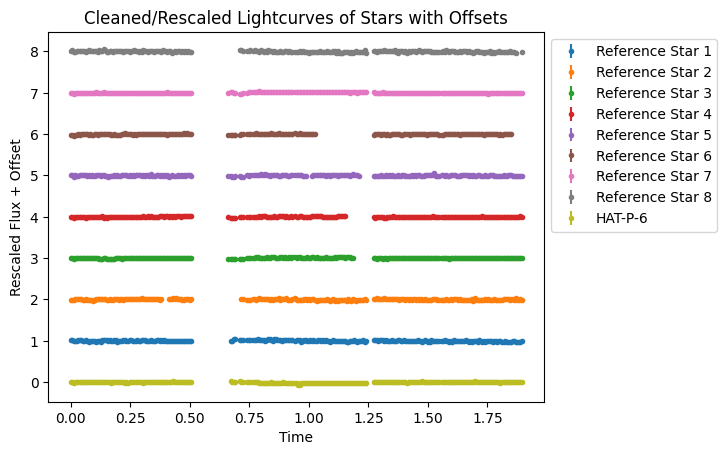

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<ErrorbarContainer object of 3 artists>

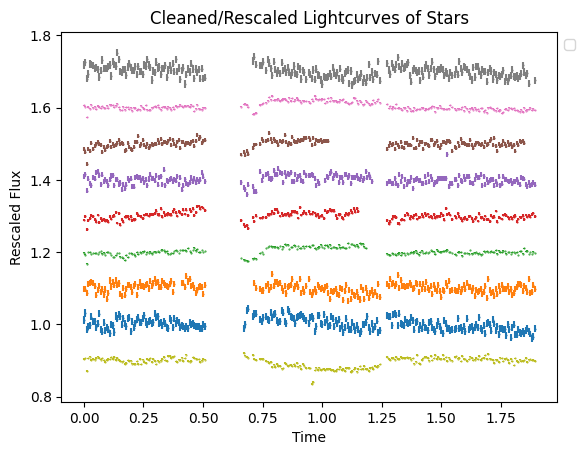

In [22]:
# Function to calculate rescaled flux and rescaled flux error
def calculate_rescaled_flux(df):
    # Calculate the median flux
    avg_flux = np.median(df['aperture_flux'])
    
    # Calculate rescaled flux and rescaled flux error
    df['rescaled_flux'] = df['aperture_flux'] / avg_flux
    df['rescaled_flux_error'] = df['aperture_flux_error'] / avg_flux
    
    return df

#we must rid arrays of data from very telescope-movement-smeared frames determined manually on ds9
smeared_times = np.array([81,102,103,105,110,111,115,116,120,197,198,199,200,245]) * (1.9/300.)

# Function to remove outliers from data based on a threshold of standard deviations
def remove_outliers(df, threshold=1):
     #threshold for within how many STDEV are we manipulating outlier data. 
    median_flux = np.median(df['rescaled_flux'])
    std_flux = np.std(df['rescaled_flux'])
    
    # Filter to keep only non-smeared frames, and only values within the threshold
    df_cleaned = df[(np.abs(df['rescaled_flux'] - median_flux) < threshold * std_flux) &
    (np.fabs(df['time'] - smeared_times[0]) > .0006) & #(df['time'] > 1.3) &
    (np.fabs(df['time'] - smeared_times[1]) > .0006) &
    (np.fabs(df['time'] - smeared_times[2]) > .0006) &
    (np.fabs(df['time'] - smeared_times[3]) > .0006) &
    (np.fabs(df['time'] - smeared_times[4]) > .0006) &
    (np.fabs(df['time'] - smeared_times[5]) > .0006) &
    (np.fabs(df['time'] - smeared_times[6]) > .0006) &
    (np.fabs(df['time'] - smeared_times[7]) > .0006) &
    (np.fabs(df['time'] - smeared_times[8]) > .0006) &
    (np.fabs(df['time'] - smeared_times[9]) > .0006) &
    (np.fabs(df['time'] - smeared_times[10]) > .0006) &
    (np.fabs(df['time'] - smeared_times[11]) > .0006) &
    (np.fabs(df['time'] - smeared_times[12]) > .0006) &
    (np.fabs(df['time'] - smeared_times[13]) > .0006)]
    return df_cleaned

# Apply rescaling and outlier removal for each reference star
reference_stars = [ref_df_1, ref_df_2, ref_df_3, ref_df_4, ref_df_5, ref_df_6, ref_df_7, ref_df_8] #all refs

cleaned_reference_stars = [] #the 8 used references
cleaned_stars = []           #all 9 stars, including HAT-P-6
for star_df in reference_stars:
    # Calculate rescaled flux and error
    star_df_rescaled = calculate_rescaled_flux(star_df)
    
    # Remove outliers after rescaling
    star_df_cleaned = remove_outliers(star_df_rescaled)
    
    # Add the cleaned dataframe to the list
    cleaned_reference_stars.append(star_df_cleaned)
    cleaned_stars.append(star_df_cleaned)
cleaned_hatp6_df = remove_outliers(calculate_rescaled_flux(hat_p_6_lightcurve_df))
cleaned_stars.append(cleaned_hatp6_df)

# Plot the cleaned and rescaled data
fig, ax = plt.subplots()

#offsets for visualization
offset = 1.0  # Initial offset
for i, star_df in enumerate(cleaned_reference_stars):
    ax.errorbar(star_df['time'], star_df['rescaled_flux']+ offset * i, 
                yerr=star_df['rescaled_flux_error'], fmt='.', label=f'Reference Star {i+1}')
ax.errorbar(cleaned_hatp6_df['time'],cleaned_hatp6_df['rescaled_flux']-1,
           yerr = cleaned_hatp6_df['rescaled_flux_error'], fmt='.', label='HAT-P-6')

#ax.plot(hat_p_6_lightcurve_df['time'],hat_p_6_lightcurve_df['aperture_flux']/np.median(hat_p_6_lightcurve_df['aperture_flux']),'.',label='HAT-P-6')
#labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Rescaled Flux + Offset')
ax.set_title('Cleaned/Rescaled Lightcurves of Stars with Offsets')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
fig, ax = plt.subplots() #above, but no offsets
ax.set_xlabel('Time')
ax.set_ylabel('Rescaled Flux')
ax.set_title('Cleaned/Rescaled Lightcurves of Stars')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
for i, star_df in enumerate(cleaned_reference_stars):
    ax.errorbar(star_df['time'], star_df['rescaled_flux'] + .1*i, 
                yerr=star_df['rescaled_flux_error'], fmt='.', label=f'Reference Star {i+1}',ms=1)
ax.errorbar(cleaned_hatp6_df['time'],cleaned_hatp6_df['rescaled_flux']-.1,
           yerr = cleaned_hatp6_df['rescaled_flux_error'], fmt='.', label='HAT-P-6',ms=1)

The lower graph makes the general profiles of the different stars clearer. There seems to be quite different behavior depending on the star, so atmospheric corrections may not be possible from these data.

## 4.5

In [9]:
#check F_i/<F_i> for a given frame, reject outliers 
#check outliers and reject data of the star in that frame to maintain proper means and weightage 
#Include all times but allow uncertainties to increase by the lower number of points sometimes present
#If the point is not there, the mean and uncertainty ignore it (appending a length-zero)
df_list = []
for t in cleaned_hatp6_df['time']:
    df_sublist = []
    df_sublist.append(t)
    fluxes = []
    uncertainties = []
    for ref_df in cleaned_reference_stars:
        df_subset = ref_df[np.fabs(ref_df['time'] - t) < .0006]
        if len(df_subset['rescaled_flux']) != 0:
            fluxes.append(df_subset['rescaled_flux'].iloc[0])
            uncertainties.append(df_subset['rescaled_flux_error'].iloc[0])
    cut_fluxes = []
    cut_uncertainties = []
    #frame_mean = np.sum(np.array(fluxes)/np.array(uncertainties)**2)/np.sum(1./np.array(uncertainties)**2)
    frame_unc = np.sqrt(1./np.sum(1./np.array(uncertainties)**2))
    for i in range(len(fluxes)):
        if np.median(np.array(fluxes)) - 2*frame_unc < fluxes[i] < np.median(np.array(fluxes)) + 2*frame_unc: 
            #set to one st.dev right now, set wider for more points.
            cut_fluxes.append(fluxes[i])
            cut_uncertainties.append(uncertainties[i])
    df_sublist.append(np.sum(np.array(cut_fluxes)/(np.array(cut_uncertainties))**
            )/np.sum(1.0/(np.array(cut_uncertainties))**2)) 
    df_sublist.append(np.sqrt(1./(np.sum(1./(np.array(cut_uncertainties))**2))))
    df_list.append(df_sublist)

#create a dataframe of times, weighted means, and uncertainties on those means from the reference stars.
#Append to it the rest of what 4.5 asks for.
final_data_df = pd.DataFrame(df_list,columns=['time','weighted_rescaled_flux_mean','weighted_rescaled_flux_error'])
science_median = np.median(hat_p_6_lightcurve_df['aperture_flux'])
final_data_df['science_flux'] = list(cleaned_hatp6_df['rescaled_flux'] * science_median)
final_data_df['science_error'] = list(cleaned_hatp6_df['rescaled_flux_error'] * science_median)

ratios = np.array(final_data_df['science_flux'])/np.array(final_data_df['weighted_rescaled_flux_mean'])
ratio_errors = ratios*np.sqrt((np.array(final_data_df['weighted_rescaled_flux_error'
    ])/np.array(final_data_df['weighted_rescaled_flux_mean']))**2+(np.array
    (final_data_df['science_error'])/np.array(final_data_df['science_flux']))**2)

final_data_df['baseline_normalized_ratio'] = ratios / np.mean(
np.array(final_data_df[final_data_df['time'] > 1.6]['science_flux']))
final_data_df['baseline_normalized_ratio_error'] = ratio_errors / np.mean(
np.array(final_data_df[final_data_df['time'] > 1.6]['science_flux']))
final_data_df = final_data_df[(final_data_df['weighted_rescaled_flux_error'] != np.inf)]
final_data_df

C:\Users\ronan\AppData\Local\Temp\ipykernel_3236\331951154.py:24: RuntimeWarning: invalid value encountered in scalar divide
  df_sublist.append(np.sum(np.array(cut_fluxes)/(np.array(cut_uncertainties))**2)/np.sum(1.0/(np.array(cut_uncertainties))**2))
C:\Users\ronan\AppData\Local\Temp\ipykernel_3236\331951154.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  df_sublist.append(np.sqrt(1./(np.sum(1./(np.array(cut_uncertainties))**2))))


,time,weighted_rescaled_flux_mean,weighted_rescaled_flux_error,science_flux,science_error,baseline_normalized_ratio,baseline_normalized_ratio_error
4,0.025333,0.996356,0.001578,47259.62,104.7245,1.012155,0.002757
7,0.044333,1.001789,0.001551,46870.96,104.3995,0.998387,0.002708
8,0.050667,0.996847,0.000688,47073.22,104.2195,1.007666,0.002337
9,0.057000,1.003843,0.001473,47263.47,104.4475,1.004688,0.002665
10,0.063333,1.000441,0.000685,47063.76,104.6573,1.003845,0.002336
...,...,...,...,...,...,...,...
257,1.855667,0.990554,0.001564,47049.67,102.4919,1.013561,0.002727
258,1.862000,0.994033,0.001533,46529.04,101.9665,0.998837,0.002676
259,1.868333,0.994730,0.000674,46879.58,102.2351,1.005657,0.002296
261,1.881000,0.991844,0.001528,46756.65,102.0042,1.005939,0.002687


The points not excluded (as of typing, 188 of the previous 259 remain) are only the most well-behaved as defined in the previous code block.

Why are so many NaNs and infs being found? probably due to the sheer spread of many of the points, which might be much greater. Since there are only 8 points or less of high spread to average in each frame, medians and means alike might be unreliable here. If we ignore points with NaNs and infs ('badly-behaved' timestamps), we come up with the below graph and stats.

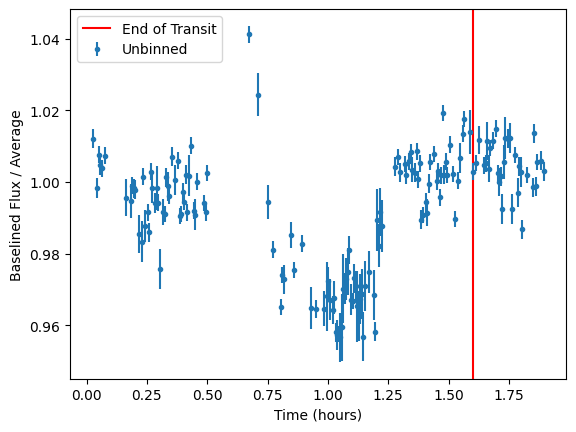

In [10]:
fig, ax = plt.subplots()
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Baselined Flux / Average')
#ax.set_ylim(0,2)
ax.axvline(1.6,color='red',label='End of Transit')
ax.errorbar(final_data_df['time'],final_data_df['baseline_normalized_ratio'
    ],yerr=final_data_df['baseline_normalized_ratio_error'],fmt='.',label='Unbinned')
ax.legend()

This has the same profile it did originally. This leads me to question the code, specifically where the divisor and dividend creating the ratio are first made. Whatever value this provides for the radius, probably don't trust it to be authentic. Note that we also assumed the transit ended when the Swarthmore transit finder suggested; we cannot measure the egress time with our data quality.

## 5

In [11]:
#final_data_df, baseline_normalized_ratio, baseline_normalized_ratio_error
during_transit_mean = np.sum(np.array(final_data_df[final_data_df['time'
] < 1.6]['baseline_normalized_ratio'])/np.array(final_data_df[final_data_df['time'
] < 1.6]['baseline_normalized_ratio_error'])**2)/np.sum(1./np.array(final_data_df[final_data_df
        ['time'] < 1.6]['baseline_normalized_ratio_error'])**2)
after_transit_mean = np.sum(np.array(final_data_df[final_data_df['time'
    ] > 1.6]['baseline_normalized_ratio'])/np.array(final_data_df[final_data_df['time'
    ] > 1.6]['baseline_normalized_ratio_error'])**2)/np.sum(1./np.array(final_data_df[
        final_data_df['time'] > 1.6]['baseline_normalized_ratio_error'])**2)

during_transit_error = np.sqrt(1./np.sum(1./np.array(final_data_df[final_data_df['time'
            ] < 1.6]['baseline_normalized_ratio_error'])))
after_transit_error = np.sqrt(1./np.sum(1./np.array(final_data_df[final_data_df['time'
            ] > 1.6]['baseline_normalized_ratio_error'])))

In [12]:
print(f" during: {during_transit_mean} +/- {during_transit_error} \n after: {
after_transit_mean} +/- {after_transit_error} ")

 during: 0.9951619461160319 +/- 0.004968227787892728 
 after: 1.004727079975129 +/- 0.009659662883065414 


There is a difference of about 1 percent in the numbers, but I have doubts it's coming from the right place. Or quantitatively:

In [13]:
#MWU-test for comparing experimental averages
after_transit = np.array(final_data_df[final_data_df['time'] > 1.6]['baseline_normalized_ratio'])
during_transit = np.array(final_data_df[final_data_df['time'] < 1.6]['baseline_normalized_ratio'])

print(mannwhitneyu(after_transit,during_transit, alternative='greater'),'\n',
     mannwhitneyu(after_transit,during_transit, alternative='less'), '\n',
     mannwhitneyu(after_transit,during_transit, alternative='two-sided'))

MannwhitneyuResult(statistic=3025.0, pvalue=6.908178058960082e-07) 
 MannwhitneyuResult(statistic=3025.0, pvalue=0.9999993244198496) 
 MannwhitneyuResult(statistic=3025.0, pvalue=1.3816356117920164e-06)


However, perhaps we ought to check after that big telescope movement at ~1.3h to compare like to like. The above results are BS because the points are clearly not in the same distribution.

In [14]:
#after the multiple-frame-long telescope movement and count gap at ~1.3 hours
print(mannwhitneyu(after_transit,final_data_df[(final_data_df['time'] > 1.3) & (
    final_data_df['time'] < 1.6)]['baseline_normalized_ratio'], alternative='greater'),'\n',
     mannwhitneyu(after_transit,final_data_df[(final_data_df['time'] > 1.3) & (
         final_data_df['time'] < 1.6)]['baseline_normalized_ratio'], alternative='less'), '\n',
     mannwhitneyu(after_transit,final_data_df[(final_data_df['time'] > 1.3) & (
    final_data_df['time'] < 1.6)]['baseline_normalized_ratio'], alternative='two-sided'))

MannwhitneyuResult(statistic=553.0, pvalue=0.21864681556714016) 
 MannwhitneyuResult(statistic=553.0, pvalue=0.7853878111450522) 
 MannwhitneyuResult(statistic=553.0, pvalue=0.4372936311342803)


Which is also what we expect based on the graph.

In [15]:
transit_depth = after_transit_mean - during_transit_mean
transit_depth_error = np.sqrt( during_transit_error**2 + after_transit_error**2)
print(f'depth = {1000*transit_depth} +/- {1000*transit_depth_error} ppt')

depth = 9.565133859096964 +/- 10.86242948731365 ppt


From the Swarthmore transit finder, the expected depth is 9.1 ppt.

Not readily evident. Why? Possibility of bugs above, high measurement uncertainty and spread trying to detect a small difference, etc.

https://arxiv.org/pdf/1704.00373 implies an area ratio of 0.0088 $\pm$ 0.00054, which agrees with Swarthmore's value. 